In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image
import time

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from sklearn.model_selection import train_test_split


basePath = "/kaggle/input/histopathologic-cancer-detection"
trainSuffix = "/train"
testSuffix = "/test"
sampleSubmission = pd.read_csv(basePath + "/sample_submission.csv")
trainingLabels = pd.read_csv(basePath + "/train_labels.csv")

2024-06-18 01:36:02.349792: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 01:36:02.349957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 01:36:02.541352: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Problem description and Data Exploration

[Link to associated GitHub](https://github.com/maniclucky/DTSA5511_Week3)

The task for this assignment is to detect the presence of cancer cells from pathology scan images.

To begin we examine the data itself. A few info and head commands show a very simple structure. In the /train and /test folders, there are the aforementioned images. The train_labels.csv contains a simple table that shows the name of each associated file, sans the .tif suffix, in the training folder as well as whether or not that image shows cancer cells, as a string and integer respectively. Given that I have no medical background, I must assume these labels to be accurate.

We can also tell, from both the info function and a look at the training folder,that there are 220,025 training images to work with. Worth noting that there is an undisclosed number of duplicate images in the training set, per the Kaggle problem description, due to probablistic sampling. For this assignment, I will be assuming them to be so few as to not bother with worrying about.

In [2]:
sampleSubmission.info()
sampleSubmission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [3]:
trainingLabels.info()
trainingLabels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## Image samples

Below are a few functionally random samples from the folders. Given that I lack any medical experience, I personally am unable to tell a difference between the cancerous and the benign samples and so would require a subject matter expert in the case that the images must be reviewed for the correctness of the labeling.

Image dimensions: 96 x 96 px


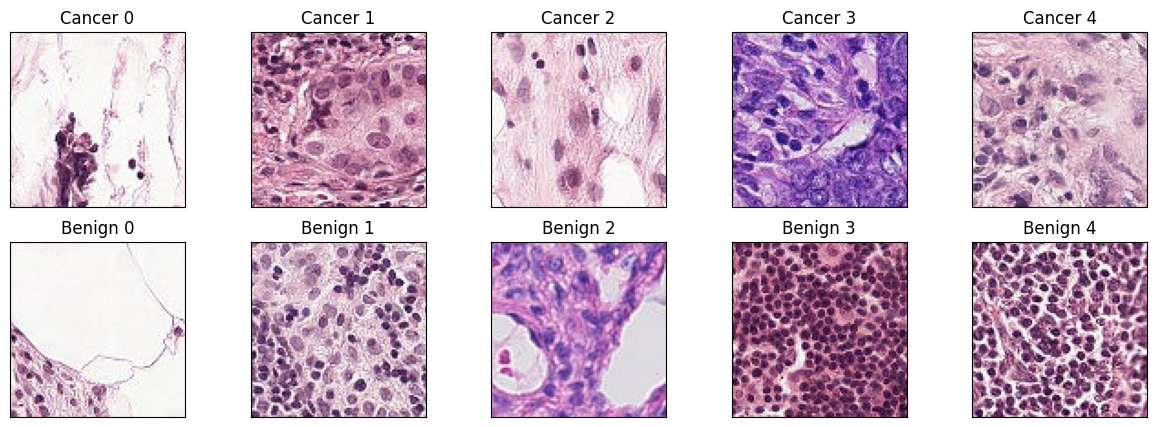

In [4]:
samplePath = basePath + trainSuffix + "/" + trainingLabels.id[0] + ".tif"
sampleImage = Image.open(samplePath)
print("Image dimensions: %s x %s px"%(sampleImage.size))

cancerImages = trainingLabels.loc[trainingLabels["label"]==1,:].reset_index()
benignImages = trainingLabels.loc[trainingLabels["label"]==0,:].reset_index()

plt.figure(figsize=(15,5))
for idx in range(5):
    samplePath = basePath + trainSuffix + "/" + cancerImages.id[idx] + ".tif"
    sampleImage = Image.open(samplePath)
    ax = plt.subplot(2,5,idx+1,title="Cancer %d"%idx)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(sampleImage)
for idx in range(5):
    samplePath = basePath + trainSuffix + "/" + benignImages.id[idx] + ".tif"
    sampleImage = Image.open(samplePath)
    ax = plt.subplot(2,5,idx+6,title="Benign %d"%idx)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(sampleImage)

## Sample Distributions

Finally, a few plots and stats to finish out the exploration.

The training labels are biased toward benign samples, which is somewhat to be expected and not so much that I would expect it to have a significant impact on the training of the data. The benign samples make up 59.5% of the dataset. This can be used as the benchmark to detect if the model is functionally guessing, and anything above that point can be considered better than nothing. I have no data on the efficacy of professionals detecting cancer manually and so have no target to shoot for. I also took the opportunity to confirm the number of images matches the number of files in the training folder.

Also shown is how the training vs the kaggle test data set is distributed for reference. While the number of expected benign or cancerous samples in the test data can be inferred, it's not terribly useful to do so.

Number of train/test samples: 220025/57458
  Number of training samples matches table size
Percentage of total samples for training: 79.29
Number/percentage of noncancerous samples: 130908, 59.50


([<matplotlib.patches.Wedge at 0x7f09a3e17190>,
 [Text(-0.87534251278466, 0.6661647583832677, 'Train'),
  Text(0.8753424504138104, -0.6661648403387453, 'Test')],
 [Text(-0.4774595524279963, 0.36336259548178235, '79.29'),
  Text(0.4774595184075329, -0.36336264018477016, '20.71')])

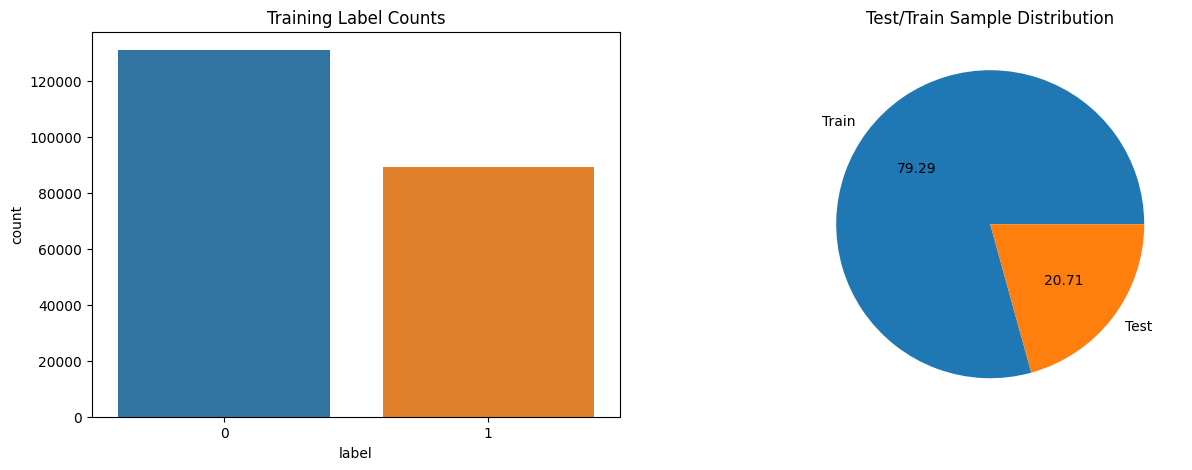

In [5]:
testCount = len(os.listdir(basePath+testSuffix))
trainCount = len(os.listdir(basePath+trainSuffix))
totalCount = testCount+trainCount
train0 = sum(trainingLabels.label==0)

print("Number of train/test samples: %d/%d"%(trainCount,testCount))
if trainCount == trainingLabels.shape[0]:
    print("  Number of training samples matches table size")
else:
    print("  Number of training samples DOES NOT match table size")
print("Percentage of total samples for training: %.2f"%(100*trainCount/totalCount))
print("Number/percentage of noncancerous samples: %d, %.2f"%(train0,100*train0/trainCount))
# print("Expected number of test
plt.figure(figsize=(15,5))
ax = plt.subplot(1,2,1,title="Training Label Counts")
sns.countplot(x="label", data=trainingLabels)
ax = plt.subplot(1,2,2,title="Test/Train Sample Distribution")
ax.pie([trainCount/totalCount*100,testCount/totalCount*100],labels=["Train","Test"],autopct="%.2f")

# Preprocessing

Before building the model, a few preprocessing steps need to be taken. Given the simplicity of the input data set, very little needs to be done. First, the training labels dataframe is updated such that the image names are suffixed with .tif so that the generator functions can use them effectively. Secondly, the label is cast as a string such that the categorizing function can accept the input, since I had issues with it not automatically converting the numeric value. Additionally, all the images were rescaled to have values between 0-1 instead of 0-255 for computational efficiency. Finally, the dataset was randomly subset into 50,000 samples. This was to speed up building and testing the model. When run without subsetting, it required several hours simply to load the data. Given that this is a homework assignment, rapid construction and assesment was prioritized over utilization of the full dataset.

Were this a real task, I would take this method and then, once I was reasonably sure that the model would train into something useful, I would incorporate the full dataset to maximize robustness.

In [6]:
trainingLabels['label'] = trainingLabels['label'].astype(str)
trainingLabels['id'] = trainingLabels['id'].apply(lambda x: x+'.tif')

sampleData = trainingLabels.sample(n=50000)

subTrain,subVal = train_test_split(sampleData,test_size=.2)

In [7]:
trainGen = ImageDataGenerator(rescale=1/255)

imageSize = (64,64)
batchSize = 256

trainData = trainGen.flow_from_dataframe(
    dataframe = subTrain,
    directory = basePath+trainSuffix,
    x_col = "id",
    y_col = "label",
    target_size = imageSize,
    batch_size = batchSize,
    class_mode='binary',
    subset='training',
    shuffle=True
)

valData = trainGen.flow_from_dataframe(
    dataframe = subVal,
    directory = basePath+trainSuffix,
    x_col = "id",
    y_col = "label",
    target_size = imageSize,
    batch_size = batchSize,
    class_mode='binary',
    subset='training',
    shuffle=True
)

Found 40000 validated image filenames belonging to 2 classes.
Found 10000 validated image filenames belonging to 2 classes.


## Model 1

For the first model, I will be taking a very simple approach. A pair of 3x3 convolutional layers, with 16 filters followed by a dense layer with 64 neurons and finally the output layer. This approach is not expected to do significantly well off hand. It is so taken to gauge things such as task complexity and proneness to overfitting. Should the task do well in training and poor in validation, efforts to address overfitting would need to be implemented. If the training accuracy doesn't pass the 59.5% threshold by a significant margin, than a deeper examination of the model itself is in order. Almost certainly to adjust the existing layers as well as adding more hidden layers. Given the simplicity of the model, vanishing and exploding gradients are not expected.

For fitting, we'll be using binary crossentropy loss due to it being a binary problem. We'll also be tracking accuraccy and recall as metrics. Given the severity of a cancer diagnosis, maximizing recall is a very important task.

In [8]:
keras.backend.clear_session()
model_1 = keras.models.Sequential()
model_1.add(keras.layers.Conv2D(16,(3,3),activation="relu",input_shape=(64,64,3)))
model_1.add(keras.layers.MaxPooling2D((2,2)))
model_1.add(keras.layers.Conv2D(16,(3,3),activation="relu"))
model_1.add(keras.layers.Flatten())
model_1.add(keras.layers.Dense(64,activation="relu"))
model_1.add(keras.layers.Dense(1,activation="sigmoid"))
model_1.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       861,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 864,081 (3.30 MB)

 Trainable params: 864,081 (3.30 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model_1.compile(optimizer="adam",
               loss = 'binary_crossentropy',
               metrics=['accuracy',Recall(name="recall")])

history = model_1.fit(
    trainData,
    epochs=10,
    validation_data = valData,
    batch_size=batchSize
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.6559 - loss: 0.6506 - recall: 0.4154 - val_accuracy: 0.7832 - val_loss: 0.4713 - val_recall: 0.7283
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 119s 738ms/step - accuracy: 0.7850 - loss: 0.4664 - recall: 0.7114 - val_accuracy: 0.7832 - val_loss: 0.4632 - val_recall: 0.7377
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 121s 749ms/step - accuracy: 0.7939 - loss: 0.4545 - recall: 0.7232 - val_accuracy: 0.7778 - val_loss: 0.4731 - val_recall: 0.8122
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 122s 754ms/step - accuracy: 0.7983 - loss: 0.4433 - recall: 0.7282 - val_accuracy: 0.7948 - val_loss: 0.4501 - val_recall: 0.6866
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 118s 731ms/step - accuracy: 0.8087 - loss: 0.4285 - recall: 0.7441 - val_accuracy: 0.7930 - val_loss: 0.4459 - val_recall: 0.6742
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 118s 731ms/step - accuracy: 0.8094 - loss: 0.4294 - recall: 0.7360 - val_accuracy: 0.7945 - val_loss: 0.4484 - val_recall: 0

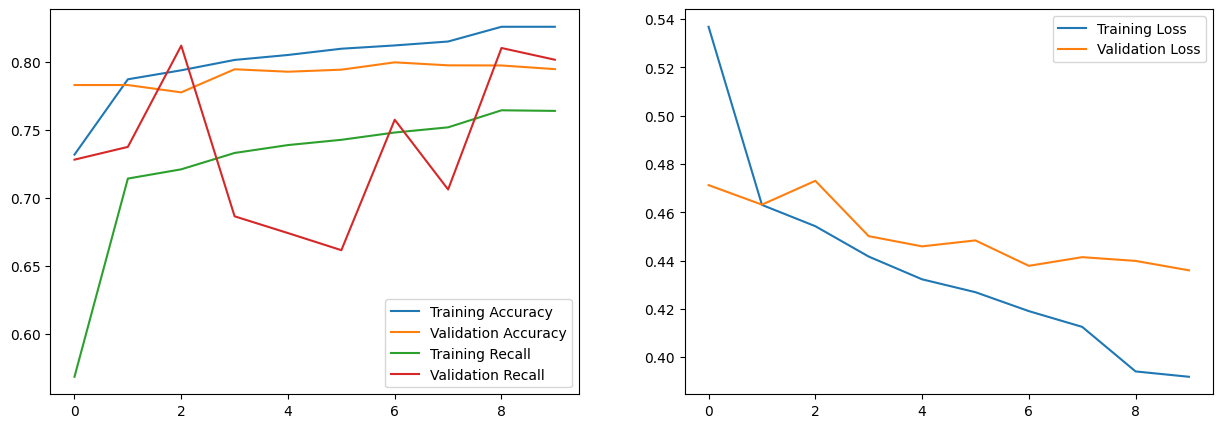

In [10]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,2,1)
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.plot(history.history['recall'])
ax.plot(history.history['val_recall'])
ax.legend(["Training Accuracy","Validation Accuracy","Training Recall","Validation Recall"])

ax = plt.subplot(1,2,2)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.legend(["Training Loss","Validation Loss"])

## Model 2

The second model is an expansion of the first. As noted above, the first model was not expected to do exceptionally well. It did better than I was expecting. ~80% validation accuracy is nothing to sneeze at. In theory, if one has a few images from a patient, one could ensemble this model into something useful were it not for the next point. Crucially, it clearly overfit on the training data, as shown by the gap between training and validation loss. While promising that such a simple model could do anything, it's ineffective for the task.

For the second model, increased complexity was attempted in addition to incorporating dropout to address some overfitting. An additional convolutional and dense layer was added to the appropriate portions of the model. The convolutional layers hand all their filters increased to 32. Each of the now two dense layers had a dropout layer added at a 0.25 dropout proportion. Both still have 64 neurons. Finally, an early stopping function was added to the fitter with a patience of 3 epochs. Should the validation loss not improve within 3 epochs from any given point, the fit will be stopped and the best weights will be returned. In theory, this should cut off one avenue of overfitting.

In [11]:
model_2 = keras.models.Sequential()
model_2.add(keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(64,64,3)))
model_2.add(keras.layers.MaxPooling2D((2,2)))
model_2.add(keras.layers.Conv2D(32,(3,3),activation="relu"))
model_2.add(keras.layers.MaxPooling2D((2,2)))
model_2.add(keras.layers.Conv2D(32,(3,3),activation="relu"))
model_2.add(keras.layers.Flatten())
model_2.add(keras.layers.Dense(64,activation="relu"))
model_2.add(keras.layers.Dropout(.25))
model_2.add(keras.layers.Dense(64,activation="relu"))
model_2.add(keras.layers.Dropout(.25))
model_2.add(keras.layers.Dense(1,activation="sigmoid"))
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,593 (1.22 MB)

 Trainable params: 318,593 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_2.compile(optimizer="adam",
               loss = "binary_crossentropy",
               metrics=["accuracy",Recall(name="recall")])

history_2 = model_2.fit(
    trainData,
    epochs=10,
    validation_data = valData,
    callbacks=[earlyStopping]
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 156s 958ms/step - accuracy: 0.6922 - loss: 0.5764 - recall: 0.3955 - val_accuracy: 0.7693 - val_loss: 0.4814 - val_recall: 0.5790
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.7826 - loss: 0.4769 - recall: 0.6857 - val_accuracy: 0.7865 - val_loss: 0.4643 - val_recall: 0.6135
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 151s 936ms/step - accuracy: 0.7936 - loss: 0.4564 - recall: 0.6996 - val_accuracy: 0.8003 - val_loss: 0.4393 - val_recall: 0.6925
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 151s 940ms/step - accuracy: 0.8049 - loss: 0.4374 - recall: 0.7338 - val_accuracy: 0.8066 - val_loss: 0.4352 - val_recall: 0.7041
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 201s 934ms/step - accuracy: 0.8082 - loss: 0.4302 - recall: 0.7233 - val_accuracy: 0.8122 - val_loss: 0.4201 - val_recall: 0.6811
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 148s 920ms/step - accuracy: 0.8134 - loss: 0.4167 - recall: 0.7372 - val_accuracy: 0.8180 - val_loss: 0.4061 - va

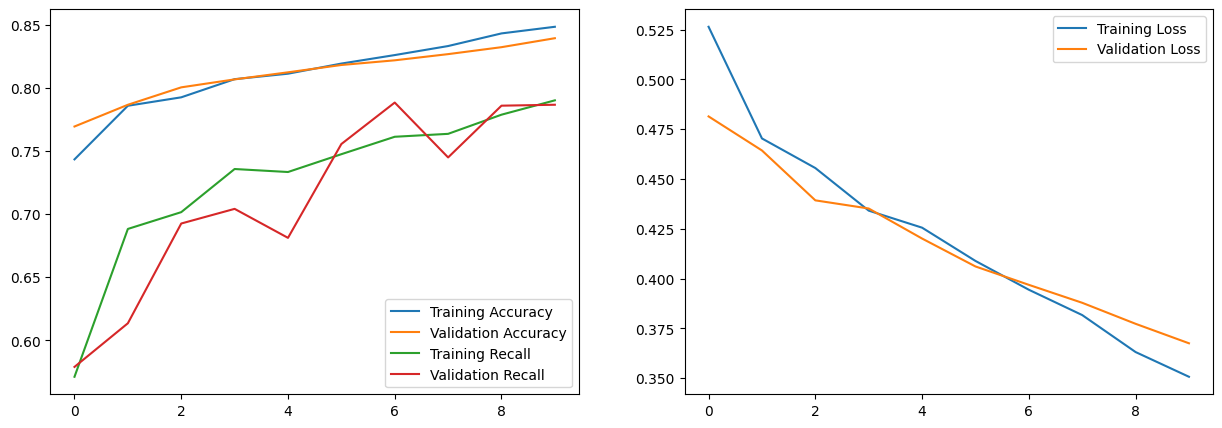

In [13]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,2,1)
ax.plot(history_2.history['accuracy'])
ax.plot(history_2.history['val_accuracy'])
ax.plot(history_2.history['recall'])
ax.plot(history_2.history['val_recall'])
ax.legend(["Training Accuracy","Validation Accuracy","Training Recall","Validation Recall"])

ax = plt.subplot(1,2,2)
ax.plot(history_2.history['loss'])
ax.plot(history_2.history['val_loss'])
ax.legend(["Training Loss","Validation Loss"])

## Submission Generation

In [14]:
testDatagen = ImageDataGenerator(rescale=1/255)
testFiles = os.listdir(basePath+testSuffix)
testDataframe = pd.DataFrame(testFiles,columns=["id"])
testDataframe["label"] = np.zeros(testDataframe.shape[0])
testDataframe["label"] = testDataframe["label"].astype(int).astype(str)
testGenerator = testDatagen.flow_from_dataframe(
    dataframe=testDataframe,
    directory = basePath+testSuffix,
    x_col='id',
    y_col='label',
    target_size = (64,64)
)

Found 57458 validated image filenames belonging to 1 classes.


In [15]:
predictions = model_2.predict(testGenerator)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 463s 258ms/step


In [16]:
submission = testDataframe
submission["label"] = (predictions>=.5).astype(int)
submission["id"] = submission["id"].map(lambda x: x[:-4])
submission.to_csv("submission.csv")

## Conclusion

The first model showed that the approach was not inherently unviable. The overfitting and not outstanding predictive capabilities marked it as unusable, but fixable. The second model, which was submitted, worked significantly better with not too much adjustment. It is still insufficient for it's theoretical task I suspect, but it is interesting nonetheless. Were this pursued further, I'd like to know more about the subject to better assess what is reasonable in terms of efficacy.

There are a variety of approaches that could further improve the model. Above, it was mentioned that I subset the training data for the sake of speed. Either model would be positively impacted from having access to the full data set. Related, but minor, detection and removal of duplicate images would be technically useful, though I suspect it would be trivially so. Tuning the hyperparameters is always an avenue, though the final model does reasonably well. Obtaining data on how effective oncologists and radiologists are at spotting cancerous samples would be useful data for benchmarking. Finally, some basic image manipulation would likely add to the data's robustness. Jitter and mirroring would likely help the model train better. Though given the size of the data set, it is ambiguous how much it would help.

The model began in a very simplistic state and the improvements were shotgunned upon it. There was little I could do to make the base model worse beyond actively incorrect things, such as using relu activation on the output layer. A better approach would have been to implement the improvements more incrementally such that useless additions could be caught. Given that this is a homework assignment and no one's lives depend on this analysis, the rapid development approach was ultimatly satisfactory.